# heart


In [1]:
%matplotlib inline

In [2]:
!pip install geomloss[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.7 MB/s 
     |████████████████████████████████| 213 kB 51.5 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
  Created wheel for geomloss: filename=geomloss-0.2.5-py3-none-any.whl size=32068 sha256=049f3e529953fd6aa839d30a4c15d248bf48a2738c2ce6c6079a28bcc4be97be
  Stored in directory: /root/.cache/pip/wheels/40/12/eb/2045cd22eaf9aa12e328e03ce2bf0304b70f49510c6ad0ce7b
  Created wheel for pykeops: filename=pykeops-2.1-py3-none-any.whl size=112038 sha256=5135616c98f2e3b232a5913779cda0b069567895934ce843042d79f6e5ade2aa
  Stored in directory: /root/.cache/pip/wheels/71/c6/7f/aec0ea12e8a3701beb441b8b79d5b6a5c5851b0571648f7d49
  Created wheel for keopscore: filename=keopscore-2.1-py3-none-any.whl size=147474 sha256=5161618c4ae08d1673dba6909bb2c3733a9315739cf289daeeb139036b244cc0
  Stored in directory: /root/.cache/pip/wheels/fb/33/bc/9

In [3]:
import numpy as np
import torch
import os

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
numpy = lambda x: x.detach().cpu().numpy()
# numpy = lambda x: x.cpu().data.numpy()

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from geomloss import SamplesLoss
from pykeops.torch import LazyTensor

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [4]:
def to_measure(points, triangles):
    """Turns a triangle into a weighted point cloud."""

    # Our mesh is given as a collection of ABC triangles:
    A, B, C = points[triangles[:, 0]], points[triangles[:, 1]], points[triangles[:, 2]]

    # Locations and weights of our Dirac atoms:
    X = (A + B + C) / 3  # centers of the faces
    S = np.sqrt(np.sum(np.cross(B - A, C - A) ** 2, 1)) / 2  # areas of the faces

    print(
        "File loaded, and encoded as the weighted sum of {:,} atoms in 3D.".format(
            len(X)
        )
    )

    # We return a (normalized) vector of weights + a "list" of points
    return tensor(S / np.sum(S)), tensor(X)

In [5]:
!pip install plyfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from plyfile import PlyData, PlyElement


def load_ply_file(fname):
    """Loads a .ply mesh to return a collection of weighted Dirac atoms: one per triangle face."""

    # Load the data, and read the connectivity information:
    plydata = PlyData.read(fname)
    triangles = np.vstack(plydata["face"].data["vertex_indices"])

    # Normalize the point cloud, as specified by the user:
    points = np.vstack([[v[0], v[1], v[2]] for v in plydata["vertex"]])

    return to_measure(points, triangles)

In [7]:
def display_cloud(ax, measure, color):

    w_i, x_i = numpy(measure[0]), numpy(measure[1])

    ax.view_init(elev=110, azim=-90)
    # ax.set_aspect('equal')

    weights = w_i / w_i.sum()
    ax.scatter(x_i[:, 0], x_i[:, 1], x_i[:, 2], s=25 * 500 * weights, c=color)

    ax.axes.set_xlim3d(left=-1.4, right=1.4)
    ax.axes.set_ylim3d(bottom=-1.4, top=1.4)
    ax.axes.set_zlim3d(bottom=-1.4, top=1.4)

In [8]:
!pip install pyvtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyvtk: filename=PyVTK-0.5.18-py3-none-any.whl size=24735 sha256=34133ba83d0a34dd37ee157bc2e21d0f9ff0486851d577ce68823890e33326d4
  Stored in directory: /root/.cache/pip/wheels/83/bb/df/9d8af5e23c0eb53cc886ded8ce7765973ddc7442423cf7890c
Successfully built pyvtk


In [9]:
folder = "output/heart_3D/"
os.makedirs(os.path.dirname("output/heart_3D/"), exist_ok=True)

from pyvtk import PolyData, PointData, CellData, Scalars, VtkData, PointData


def save_vtk(fname, points, colors):
    """N.B.: Paraview is a good VTK viewer, which supports ray-tracing."""

    structure = PolyData(points=points, vertices=np.arange(len(points)))
    values = PointData(Scalars(colors, name="colors"))
    vtk = VtkData(structure, values)

    vtk.tofile(folder + fname, "binary")

In [10]:
fast_demo = False 

Npoints = 4e6 # number of points in the mesh

In [12]:
mypath = '/content/data/Myocardium/'
from os import listdir
from os.path import isfile, join
heartfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
sorted_heart = sorted(heartfiles, key=lambda x: float(x[14:-4]))


In [18]:
print("Loading the Myocardium data:")
# N.B.: Since Plyfile is far from being optimized, this may take some time!
targets = [load_ply_file(mypath+p) for p in sorted_heart]
# targets = [
#     load_ply_file("/content/data/Myocardium/RSGs_4D_MYO_t_1.0000.ply"),
#     load_ply_file("/content/data/RSGs_4D_MYO_t_2.0000.ply"),
#     load_ply_file("/content/data/RSGs_4D_MYO_t_3.0000.ply"),
# ]

Loading the Myocardium data:
File loaded, and encoded as the weighted sum of 29,922 atoms in 3D.
File loaded, and encoded as the weighted sum of 29,922 atoms in 3D.
File loaded, and encoded as the weighted sum of 29,922 atoms in 3D.


In [13]:
mypath_S = '/content/data/Splanchnic/'
heartfiles_S = [f for f in listdir(mypath_S) if isfile(join(mypath_S, f))]
sorted_heart_S = sorted(heartfiles_S, key=lambda x: float(x[14:-4]))
targets_S = [load_ply_file(mypath_S+p) for p in sorted_heart_S]

File loaded, and encoded as the weighted sum of 42,980 atoms in 3D.
File loaded, and encoded as the weighted sum of 42,980 atoms in 3D.
File loaded, and encoded as the weighted sum of 42,980 atoms in 3D.


In [14]:
mypath_P = '/content/data/Paraxial/'
heartfiles_P = [f for f in listdir(mypath_P) if isfile(join(mypath_P, f))]
sorted_heart_P = sorted(heartfiles_P, key=lambda x: float(x[14:-4]))
targets_P = [load_ply_file(mypath_P+p) for p in sorted_heart_P]

File loaded, and encoded as the weighted sum of 185,916 atoms in 3D.
File loaded, and encoded as the weighted sum of 104,560 atoms in 3D.
File loaded, and encoded as the weighted sum of 104,560 atoms in 3D.


In [15]:
mypath_O = '/content/data/Splanchnic/'
heartfiles_O = [f for f in listdir(mypath_O) if isfile(join(mypath_O, f))]
sorted_heart_O = sorted(heartfiles_O, key=lambda x: float(x[14:-4]))
targets_O = [load_ply_file(mypath_O+p) for p in sorted_heart_O]

File loaded, and encoded as the weighted sum of 42,980 atoms in 3D.
File loaded, and encoded as the weighted sum of 42,980 atoms in 3D.
File loaded, and encoded as the weighted sum of 42,980 atoms in 3D.


In [19]:
targets = [list(i) for i in targets]
for i in range(len(targets)):
  targets[i][0] = torch.cat((targets[i][0], targets_S[i][0], targets_P[i][0], targets_O[i][0]), 0)
  targets[i][1] = torch.cat((targets[i][1], targets_S[i][1], targets_P[i][1], targets_O[i][1]), 0)

In [20]:
K = 12
colors = (K * targets[0][1][:, 0]).cos()
colors = colors.view(-1).detach().cpu().numpy()


In [21]:
def normalize(measure, n=None):
    """Reduce a point cloud to at most n points and normalize the weights and point cloud."""
    weights, locations = measure
    N = len(weights)

    if n is not None and n < N:
        n = int(n)
        indices = torch.randperm(N)
        indices = indices[:n]
        weights, locations = weights[indices], locations[indices]

    weights = weights / weights.sum()
    weights, locations = weights.contiguous(), locations.contiguous()

    # Center, normalize the point cloud
    mean = (weights.view(-1, 1) * locations).sum(dim=0)
    locations -= mean
    std = (weights.view(-1) * (locations ** 2).sum(dim=1).view(-1)).sum().sqrt()
    locations /= std

    return weights, locations


targets = [normalize(t, n=Npoints) for t in targets]
# init_h_0 = normalize(init_h, n=Npoints)

In [22]:
import time

Loss = SamplesLoss("sinkhorn", p=2, blur=0.01, scaling=0.5, truncate=1)


def OT_registration(source, target, name):
    a, x = source  # weights, locations
    b, y = target  # weights, locations

    x.requires_grad = True
    z = x.clone()  # Moving point cloud

    if use_cuda:
        torch.cuda.synchronize()
    start = time.time()

    nits = 4 if fast_demo else 10

    for it in range(nits):
        wasserstein_zy = Loss(a, z, b, y)
        [grad_z] = torch.autograd.grad(wasserstein_zy, [z])
        z -= grad_z / a[:, None]  # Apply the regularized Brenier map

        # save_vtk(f"matching_{name}_it_{it}.vtk", numpy(z), colors)

    end = time.time()
    print("Registered {} in {:.3f}s.".format(name, end - start))

    return z


In [23]:
matchings = [
    OT_registration(targets[0], target, f"shape{i+1}")
    for (i, target) in enumerate(targets[1:])
]

[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat(Var(2,1,1)-Var(3,1,2)*(((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))/2),1),0) ... OK
[KeOps] Generating code for formula Max_SumShiftExpWeight_Reduction(Concat(Var(2,1,1)-Var(3,1,2)*(((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))/2),1),0) ... 

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OK
[KeOps] Generating code for formula Sum_Reduction(-((2*((Var(3,1,2)*(Extract(Var(4,2,0),1,1)*Exp((Var(2,1,1)-Var(3,1,2)*(((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))/2))-Extract(Var(5,2,0),0,1))))/2))*(Var(0,3,0)-Var(1,3,1))),0) ... OK
Registered shape1 in 43.214s.
Registered shape2 in 29.598s.


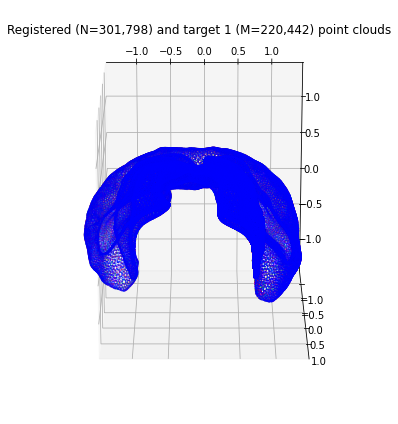

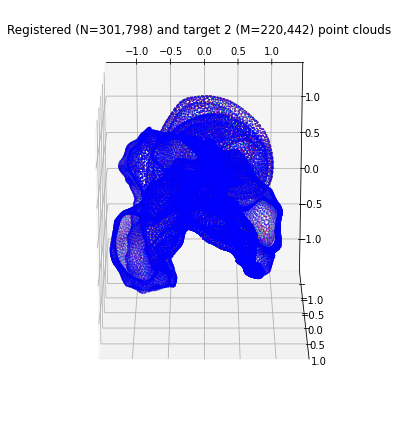

In [24]:
for (i, (matching, target)) in enumerate(zip(matchings, targets[1:])):

    fig = plt.figure(figsize=(6, 6))
    plt.set_cmap("hsv")

    ax = fig.add_subplot(1, 1, 1, projection="3d")

    display_cloud(ax, (targets[0][0], matching), colors)
    display_cloud(ax, target, "blue")
    ax.set_title(
        "Registered (N={:,}) and target {} (M={:,}) point clouds".format(
            len(matching), i + 1, len(target[0])
        )
    )
    plt.tight_layout()

In [38]:
FPS = 32

source = targets[0][1]
pairs = [
    # (source, source),
    (source, matchings[0]),
    # (matchings[0], matchings[0]),
]

In [39]:
for i in range(len(targets)-2):
    pairs.append((matchings[i], matchings[i+1]))
    # pairs.append((matchings[i+1], matchings[i+1]))

In [40]:
frame = 0

print("Save as a VTK movie...", end="", flush=True)
for (A, B) in pairs:
    A, B = numpy(A), numpy(B)
    for t in np.linspace(0, 1, FPS):
        save_vtk(f"frame_{frame}.vtk", (1 - t) * A + t * B, colors)
        frame += 1

print("Done.")
plt.show()

Save as a VTK movie...Done.


In [41]:
!zip -r /content/heart.zip /content/output/heart_3D

  adding: content/output/heart_3D/ (stored 0%)
  adding: content/output/heart_3D/frame_52.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_46.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_32.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_16.vtk (deflated 27%)
  adding: content/output/heart_3D/frame_54.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_17.vtk (deflated 27%)
  adding: content/output/heart_3D/frame_8.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_31.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_5.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_15.vtk (deflated 27%)
  adding: content/output/heart_3D/frame_38.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_20.vtk (deflated 27%)
  adding: content/output/heart_3D/frame_33.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_35.vtk (deflated 26%)
  adding: content/output/heart_3D/frame_23.vtk (deflated 26%)
  adding: content/output/

In [42]:
from google.colab import files
files.download("/content/heart.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
!rm -rf '/content/output/heart_3D'

In [ ]:
!unzip "/content/smalldata/data.zip" -d "/content/smalldata/"

Archive:  /content/smalldata/data.zip
   creating: /content/smalldata/data/
   creating: /content/smalldata/data/Splanchnic/
  inflating: /content/smalldata/data/Splanchnic/RSGs_4D_SPL_t_6.0000.ply  
   creating: /content/smalldata/__MACOSX/
   creating: /content/smalldata/__MACOSX/data/
   creating: /content/smalldata/__MACOSX/data/Splanchnic/
  inflating: /content/smalldata/__MACOSX/data/Splanchnic/._RSGs_4D_SPL_t_6.0000.ply  
  inflating: /content/smalldata/data/Splanchnic/RSGs_4D_SPL_t_4.0000.ply  
  inflating: /content/smalldata/__MACOSX/data/Splanchnic/._RSGs_4D_SPL_t_4.0000.ply  
  inflating: /content/smalldata/data/Splanchnic/RSGs_4D_SPL_t_5.0000.ply  
  inflating: /content/smalldata/__MACOSX/data/Splanchnic/._RSGs_4D_SPL_t_5.0000.ply  
  inflating: /content/smalldata/__MACOSX/data/._Splanchnic  
   creating: /content/smalldata/data/Paraxial/
  inflating: /content/smalldata/data/Paraxial/RSGs_4D_HPM_t_5.0000.ply  
   creating: /content/smalldata/__MACOSX/data/Paraxial/
  inflat